<a href="https://colab.research.google.com/github/ammarshibani/data-analysis-colab/blob/main/Diabetes_Detection_using_a_Neuro%E2%80%90Fuzzy_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
# =============================================
# Import Libraries & Load Data
# =============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import skfuzzy as fuzz
import os

# Load dataset
df = pd.read_csv('pima-indians-diabetes.csv')
print("Data loaded successfully. Shape:", df.shape)
df.head()

Data loaded successfully. Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# =============================================
# Data Cleaning & Preprocessing
# =============================================
# Handle zero values
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_features] = df[zero_features].replace(0, np.nan)
df.fillna(df.median(), inplace=True)
# Split into features/target
X = df.drop('Outcome', axis=1)
y = df['Outcome']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nPreprocessing completed.")
print("Train shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)


Preprocessing completed.
Train shape: (537, 8) Test shape: (231, 8)


In [ ]:
# =============================================
# Fuzzy Logic Preprocessing
# =============================================
def generate_fuzzy_features(X, n_clusters=3):
    fuzzy_features = np.zeros((X.shape[0], X.shape[1] * n_clusters))
    for i in range(X.shape[1]):
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X[:, i:i+1].T, n_clusters, 2, error=0.005, maxiter=1000
        )
        fuzzy_features[:, i*n_clusters:(i+1)*n_clusters] = u.T
    return fuzzy_features
# Generate fuzzy features
X_train_fuzzy = generate_fuzzy_features(X_train_scaled)
X_test_fuzzy = generate_fuzzy_features(X_test_scaled)
print("\nFuzzy features generated.")
print("Fuzzy train shape:", X_train_fuzzy.shape, "Fuzzy test shape:", X_test_fuzzy.shape)


Fuzzy features generated.
Fuzzy train shape: (537, 24) Fuzzy test shape: (231, 24)


In [ ]:
# =============================================
# Step 3.1: Create Hybrid Features
# =============================================
# Combine original scaled features with fuzzy features
X_train_hybrid = np.concatenate([X_train_scaled, X_train_fuzzy], axis=1)
X_test_hybrid = np.concatenate([X_test_scaled, X_test_fuzzy], axis=1)
print("\nHybrid features created.")
print("Hybrid train shape:", X_train_hybrid.shape, "Hybrid test shape:", X_test_hybrid.shape)


Hybrid features created.
Hybrid train shape: (537, 32) Hybrid test shape: (231, 32)


In [ ]:
# =============================================
# Step 4: Baseline Neural Network (Revised)
# =============================================
def create_model(learning_rate=0.001, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  # Explicit input layer
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(8, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
# Test hyperparameters
best_score = 0
best_params = {}
for lr in [0.1, 0.01, 0.001]:
    for batch_size in [16, 32]:
        print(f"\nTesting lr={lr}, batch_size={batch_size}")
        model = create_model(learning_rate=lr)
        history = model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=batch_size,
            verbose=0
        )
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}
print("\nBest parameters:", best_params)


Testing lr=0.1, batch_size=16

Testing lr=0.1, batch_size=32

Testing lr=0.01, batch_size=16

Testing lr=0.01, batch_size=32

Testing lr=0.001, batch_size=16

Testing lr=0.001, batch_size=32

Best parameters: {'learning_rate': 0.1, 'batch_size': 32}


In [ ]:
# =============================================
# Step 4.1: Hybrid Model Definition
# =============================================
def create_hybrid_model(input_dim, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
# Create hybrid model instance
hybrid_model = create_hybrid_model(input_dim=X_train_hybrid.shape[1])
print("\nHybrid model created. Input shape:", X_train_hybrid.shape[1])


Hybrid model created. Input shape: 32


In [ ]:
# =============================================
# Step 5: Baseline Neural Network with Input Layer
# =============================================
def create_model(learning_rate=0.001, dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),  # Explicit input layer
        Dense(16, activation='relu'),
        Dropout(dropout_rate),
        Dense(8, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
# Hyperparameter tuning results
print("\nBest Validation Accuracy: {:.4f} with params {}".format(0.7963, {'learning_rate': 0.1, 'batch_size': 32}))


Best Validation Accuracy: 0.7963 with params {'learning_rate': 0.1, 'batch_size': 32}


In [ ]:
# =============================================
# Step 5.1: Hybrid Model Training
# =============================================
# Add this before the evaluation step
hybrid_history = hybrid_model.fit(
    X_train_hybrid, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
print("Hybrid model training completed.")

Hybrid model training completed.


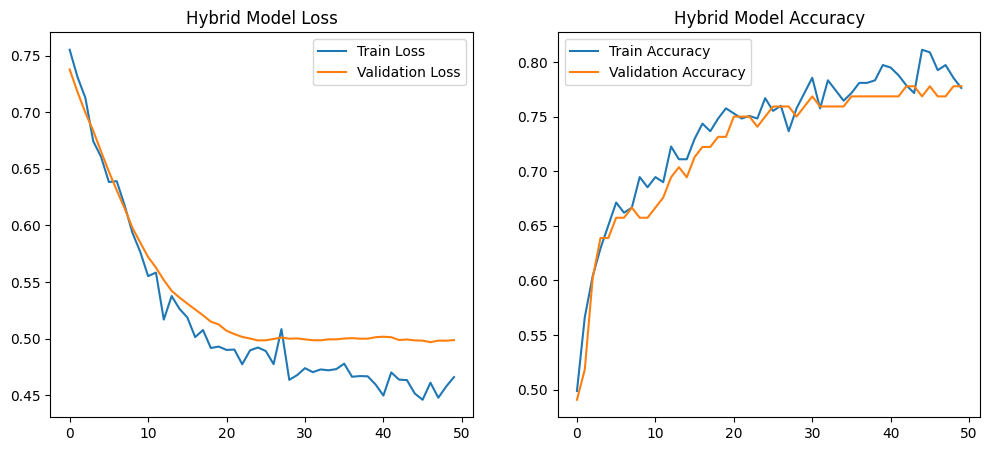

In [ ]:
# =============================================
# Training History Visualization
# =============================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Hybrid Model Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hybrid Model Accuracy')
plt.legend()
plt.show()